In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import numpy as np

# Steps

- Train loop
    - Forward
        - Conv
        - Relu
        - Conv
        - Relu
        - Dense
        - Softmax
        - Cross entropy
    
    Backprop the gradients for all the layers

    Test the code for MNIST

In [1]:
import mnist

In [12]:
mnist.init()

Download complete.
Save complete.


In [1385]:
x_train, y_train, x_test, y_test = mnist.load()

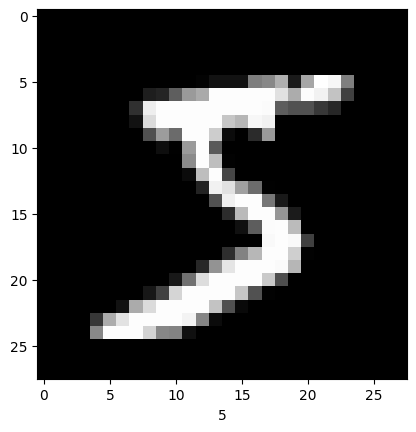

In [14]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [4]:
from layer import Layer

### Relu layer

In [5]:
class ReluLayer(Layer):
    def __init__(self, layer_name):
        super().__init__(layer_name)
        self.cached_output = None

    def forward(self, input_activations):
        self.cached_output = np.maximum(0, input_activations)
        return self.cached_output

    def backward(self, global_gradients, lr):
        local_grad = np.array(global_gradients, copy=True)
        local_grad[self.cached_output <= 0] = 0
        return local_grad

### Dense layer

In [6]:
class DenseLayer(Layer):
    def __init__(self, layer_name, input_nodes, output_nodes, debug = False):
        super().__init__(layer_name)
        self.debug = debug
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        '''
        Gloro/Xavier initialization for weights for faster convergence
        https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/
        '''
        limit = np.sqrt(2 / float(input_nodes + output_nodes))
        self.weights = np.random.normal(0.0, limit, size = (input_nodes, output_nodes))

        ''' 
        No initialization is required for bias,
        https://cs231n.github.io/neural-networks-2/#:~:text=Initializing%20the%20biases
        '''
        self.bias = np.zeros((1, output_nodes))

        #we need to cache the input and output from this layer for the purpose of backprop
        self.cached_input = None
        self.cached_output = None

    # overriden
    def forward(self, input_activations):
        '''

        @param input_activations - Output of previous layer
        @return softmax of logits

        Dense layer forward prop
        1. Flatten the input
        2. Dot product with weights and add the bias
        3. Cache the input and logits for backpop
        4. Apply softmax on logits and return it
        '''

        shape = input_activations.shape
        layer_input = input_activations.ravel().reshape(shape[0], -1)
        layer_logits = np.dot(layer_input, self.weights) + self.bias

        self.cached_input = layer_input
        self.cached_output = layer_logits
        if self.debug:
            print(f"Cached output {self.cached_output}, ip shape {layer_input.shape}, op shape {layer_logits.shape}")
        return self.cached_output


    #overriden
    def backward(self, global_gradient, current_lr):
        '''
        @param global_gradient, gradients from the previous layer
        @param current_lr 


        @returns The gradient of Loss w.r.t to the input to this layer
        i.e the input_activations recieved during forward pass.

        Dense layer backward prop
        1. Calculate the gradients w.r.t to the weights
        2. Calculate the gradients w.r.t to the received activations
        and return it for usage in other previous layers.

        '''
        output_grad  = global_gradient
        samples = global_gradient.shape[0]

        assert output_grad.shape[1] == self.weights.T.shape[0]
        assert self.cached_input.T.shape[1] == output_grad.shape[0]

        input_grad = np.dot(output_grad, self.weights.T) / samples
        weight_grad = np.dot(self.cached_input.T, output_grad) / samples
        
        if self.debug:
            print(f"weights shape {self.weights.shape}, weight grad shape {weight_grad.shape}, input_shape {self.cached_input.shape}, input_grad shape {input_grad.shape}, ")

        self.weights -= current_lr * weight_grad
        self.bias -= current_lr * np.sum(output_grad, axis=0, keepdims=True) 

        return input_grad

In [1526]:
dense_1 = DenseLayer("Dense_1",784, 10)

In [1527]:
dense_1.forward(np.random.randn(1,784)).shape

(1, 10)

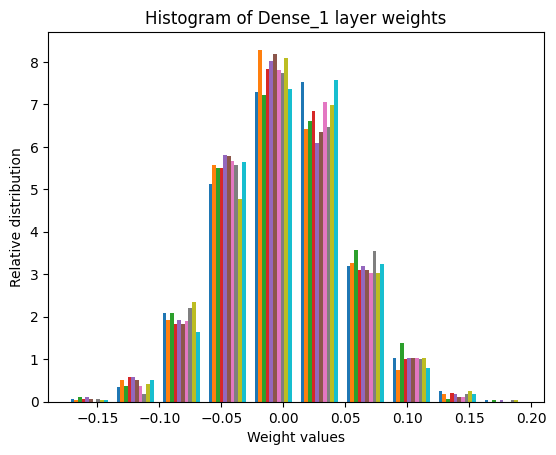

In [1528]:
import utils
utils.plot_histogram(dense_1.layer_name, dense_1.weights)

In [1529]:
28*28

784

### Model

In [1530]:
from activations import Softmax_Categorical_CrossEntropy

In [1531]:
dense_1 = DenseLayer("Dense_1", 784, 14)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

softmax_loss = Softmax_Categorical_CrossEntropy("Softmax_CCE_1")

In [1532]:
y = dense_1.forward(img1.reshape(1, 28, 28))
relu_y = relu_1.forward(y)
y = dense_2.forward(relu_y)

true_labels = y_train[0].reshape(1,1)
loss = softmax_loss.forward(y, true_labels)
print(f"loss {loss}, ypredicted {y}")

# gradients /= samples

global_grad = softmax_loss.backward(softmax_loss.cached_output, true_labels)
print(global_grad.shape)

global_grad = dense_2.backward(global_grad, 1e-6)
print(global_grad.shape)
global_grad = relu_1.backward(global_grad, 1e-6)


loss [[4.25632196e-10]], ypredicted [[  87.16281958 -132.05869179   33.24789162 -146.02762564   70.93347035
   108.74026511   59.47953431 -164.63070273    4.17366725  -43.74472093]]
(1, 10)
(1, 14)


In [1533]:
global_grad = dense_1.backward(global_grad, 1e-06)

In [1534]:
relu_y

array([[  0.        ,   9.84030006, 154.14881348, 106.55735679,
          0.        , 135.07674153,   0.        ,   0.        ,
          0.        , 122.0143427 ,   0.        , 145.27348434,
          0.        ,   0.        ]])

In [1535]:
relu_y <= 0

array([[ True, False, False, False,  True, False,  True,  True,  True,
        False,  True, False,  True,  True]])

In [1536]:
# global_grad[relu_y <= 0] = 0

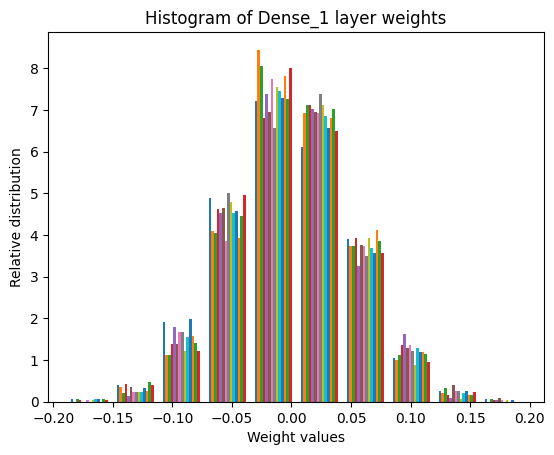

In [1537]:
utils.plot_histogram("Dense_1", dense_1.weights)

### Sequential

In [1043]:
x_train, y_train, x_test, y_test = mnist.load()

In [427]:
from model import Sequential

np.random.seed(42)

dense_1 = DenseLayer("Dense_1", 784, 14, debug=False)
relu_1 = ReluLayer("relu_1")
dense_2 = DenseLayer("Dense_2", 14, 10)

layers = [dense_1, relu_1, dense_2]
sequential_model = Sequential(layers)

In [1631]:
x_train.shape

(60000, 784)

In [1632]:
x_preprocessed = x_train[:4000]
y_preprocessed = y_train[:4000]

x_preprocessed = utils.minmax_normalize(x_preprocessed)

In [1633]:
x_val_preprocessed = x_train[4000: 6000]
y_val_preprocessed = y_train[4000: 6000]

x_val_preprocessed = utils.minmax_normalize(x_val_preprocessed)

In [1634]:
y_val_preprocessed

array([7, 3, 0, ..., 8, 6, 9], dtype=uint8)

In [1636]:
sequential_model.train([x_preprocessed, y_preprocessed], [x_val_preprocessed, y_val_preprocessed], 20, 1, debug=True, learning_rate=1e-04)

----------
Epoch 0, Time 1.5064051151275635 seconds
Train Accuracy 49.45, Validation accuracy 52.300000000000004
Train Loss [6978.57433053], Validation loss 9.316973723890248
----------
----------
Epoch 1, Time 1.4068033695220947 seconds
Train Accuracy 56.074999999999996, Validation accuracy 60.25
Train Loss [6459.62009771], Validation loss 9.21287202767249
----------
----------
Epoch 2, Time 1.387730598449707 seconds
Train Accuracy 63.849999999999994, Validation accuracy 65.64999999999999
Train Loss [5939.08125918], Validation loss 9.118789029274817
----------
----------
Epoch 3, Time 1.3815183639526367 seconds
Train Accuracy 69.925, Validation accuracy 70.85000000000001
Train Loss [5430.36958101], Validation loss 9.041238604543583
----------
----------
Epoch 4, Time 1.4282124042510986 seconds
Train Accuracy 74.97500000000001, Validation accuracy 75.1
Train Loss [4950.26825855], Validation loss 8.974339050688446
----------
----------
Epoch 5, Time 1.356957197189331 seconds
Train Accur

In [1637]:
x_test_preprocessed = x_test
y_test_preprocessed = y_test

x_test_preprocessed = utils.minmax_normalize(x_test_preprocessed)

In [1638]:
sequential_model.test([x_test_preprocessed, y_test_preprocessed])

(84.77, 10.985309858703765)

In [356]:
x_train.shape

(60000, 784)

In [429]:
permuted_idx = np.random.permutation(range(x_train.shape[0]))
x_permuted = x_train[permuted_idx]
y_permuted = y_train[permuted_idx]

7

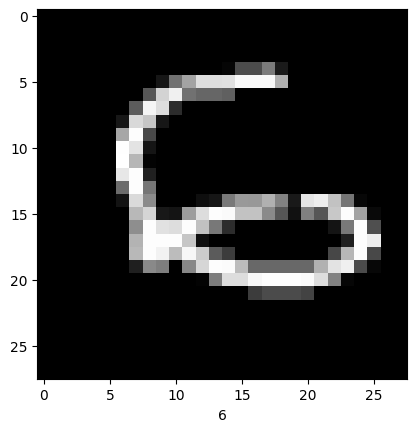

In [430]:
idx = np.random.randint(0,10000)
test_image = utils.minmax_normalize(x_permuted[idx])

plt.imshow(test_image.reshape(28, 28), cmap="gray")
plt.xlabel(y_permuted[idx])

np.argmax(sequential_model._forward(np.expand_dims(test_image, 0)))

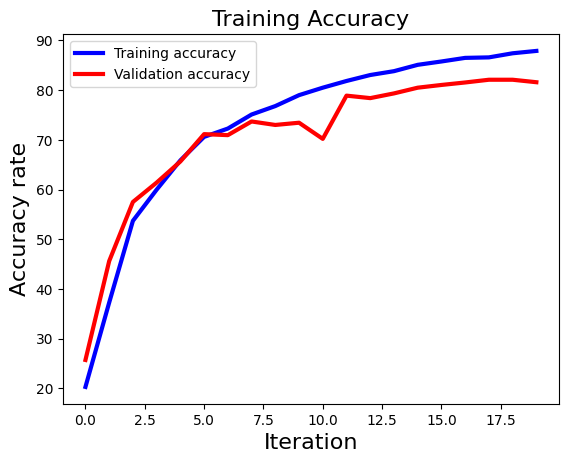

In [364]:
utils.plot_accuracy_curve(sequential_model.train_accuracy, sequential_model.validation_accuracy)

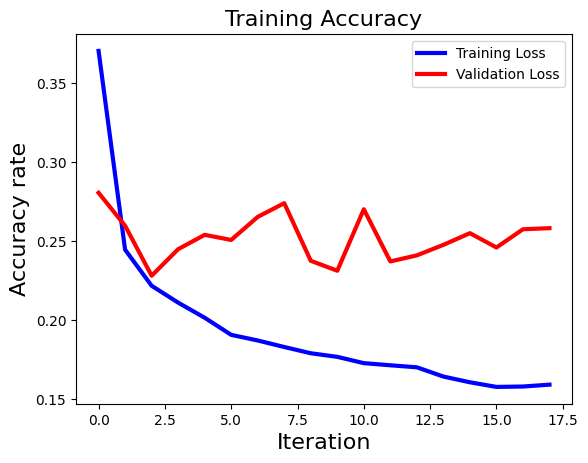

In [329]:
utils.plot_loss_curve(sequential_model.train_loss, sequential_model.validation_loss)

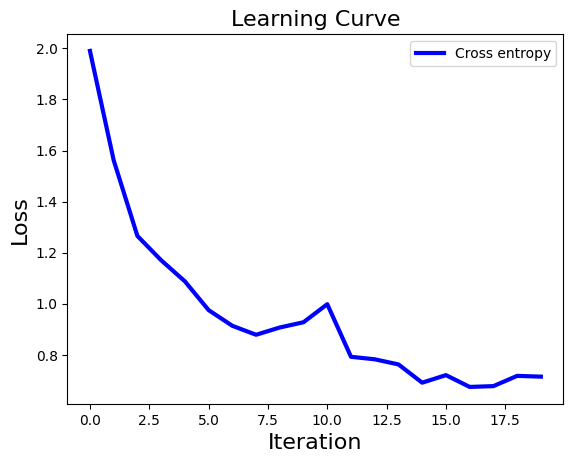

In [365]:

utils.plot_learning_curve(sequential_model.validation_loss)

# Conv layer

In [33]:
import numpy as np
from layer import Layer

In [1287]:
class ConvLayer(Layer):
    def __init__(self, layer_name, n_filters = 8, filter_size = 3, stride = 1, debug = True):
        super().__init__(layer_name)
        np.random.seed(42)
                
        self.filter_size = filter_size
        self.stride = stride
        self.n_filters = n_filters

        self.cached_input = None
        self.debug = debug
        self.cached_input_activations = None
        self.cached_output_activations = None

    def get_patch(self, image, width_idx, height_idx, filter_size):
        return image[:, :, height_idx:height_idx+filter_size, width_idx: width_idx+filter_size]

    def forward(self, input_activations):
        '''
        @param input_activations - output of previous layer, will be of shape
        N x C x H x W 
        Conv forward

        1. Get the patch of the size similar to conv filter
        2. Perform convolution on that patch and store in an numpy array
        3. Do the above for all the filters
        4. Append all the filters output and return it for next layer

        '''
        self.cached_input_activations = input_activations
        first_activation = True
        n_samples, input_channels, input_width, input_height = input_activations.shape

        if self.debug:
            print(f"{n_samples=}, {input_channels=}, {input_width=}, {input_height=}")
            
        self.conv_filter = np.random.randn(self.n_filters, input_channels, self.filter_size, self.filter_size) * 0.1

        output_shape = (int((input_width - self.filter_size) / self.stride)) + 1 
        output_activations = np.zeros([])

        for conv_filter in self.conv_filter:
            filter_output = np.zeros((n_samples, output_shape, output_shape))
            height_idx = 0
            filter_y = 0
            
            while (height_idx + self.filter_size) <= input_height:
                width_idx = 0
                filter_x = 0
                while (width_idx + self.filter_size) <= input_width:
                    patch = self.get_patch(input_activations, width_idx, height_idx, self.filter_size)
                                    
                    conv = np.sum(conv_filter * patch, axis=(1,2,3))
                    if first_activation:
                        print(f"{height_idx=}, {width_idx=}, {filter_output.shape=}, {patch.shape=}, {conv.shape=}")

                    
                    filter_output[:, filter_y, filter_x] = conv                    
                    width_idx += self.stride
                    filter_x += 1
                    
                height_idx += self.stride
                filter_y += 1
                # filter_output = filter_output.reshape(output_shape, output_shape)
            
            if first_activation:
                output_activations = filter_output
                output_activations = np.expand_dims(output_activations, axis=1)
                first_activation = False

            else:
                filter_output = np.expand_dims(filter_output, axis=1)
                print(f"{output_activations.shape=}, {filter_output.shape=}")
                output_activations = np.append(output_activations, filter_output, axis=1)

            if self.debug:
                print(f"{output_activations.shape=}, {filter_output.shape=}")

        self.cached_output_activations = output_activations
        return output_activations

    def backward(self):
        pass

In [855]:
t = np.random.randn(2, 3, 3, 3)

In [856]:
t = np.array([
    [
        [
            [1,2,3], [1,2,3]
            ],
            [
            [1,2,3], [1,2,3]
            ]
        ], 
    [
        [
            [1,2,3], [1,2,3]
            ],
            [
            [1,2,3], [1,2,3]
            ]
        ]
             ])

print(t.shape)

(2, 2, 2, 3)


In [857]:
s = t.sum(axis=(1,2,3))

In [858]:
s.shape

(2,)

In [859]:
t

array([[[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]],


       [[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]]])

In [860]:
s

array([24, 24])

In [861]:
img1.shape

(1, 1, 28, 28)

In [862]:
conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 3)

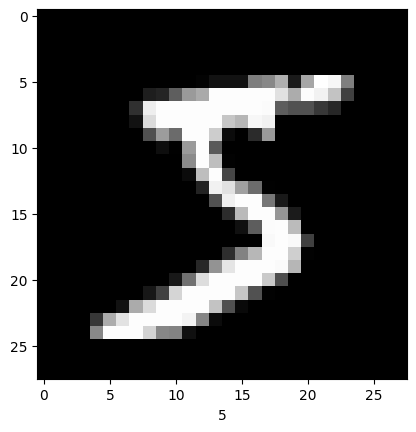

In [863]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [864]:
img1 = np.expand_dims(img1, axis=0)
img1 = np.expand_dims(img1, axis=0)

In [865]:
img1.shape

(1, 1, 28, 28)

In [866]:
conv1_activations = conv_1.forward(img1)

conv1_activations.shape

n_samples=1, input_channels=1, input_width=28, input_height=28
height_idx=0, width_idx=0, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=3, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=6, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=9, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=12, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=15, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=18, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=21, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=0, width_idx=24, filter_output.shape=(1, 9, 9), patch.shape=(1, 1, 3, 3), conv.shape=(1,)
height_idx=3, width_idx=0, filte

(1, 8, 9, 9)

In [867]:
conv1_activations[0].shape

(8, 9, 9)

In [868]:
conv1_activations.shape

(1, 8, 9, 9)

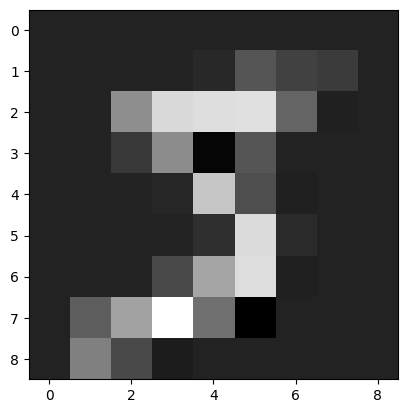

In [869]:
h = conv1_activations.shape[1]
w = conv1_activations.shape[2]
plt.imshow(conv1_activations[0][7], cmap="gray")

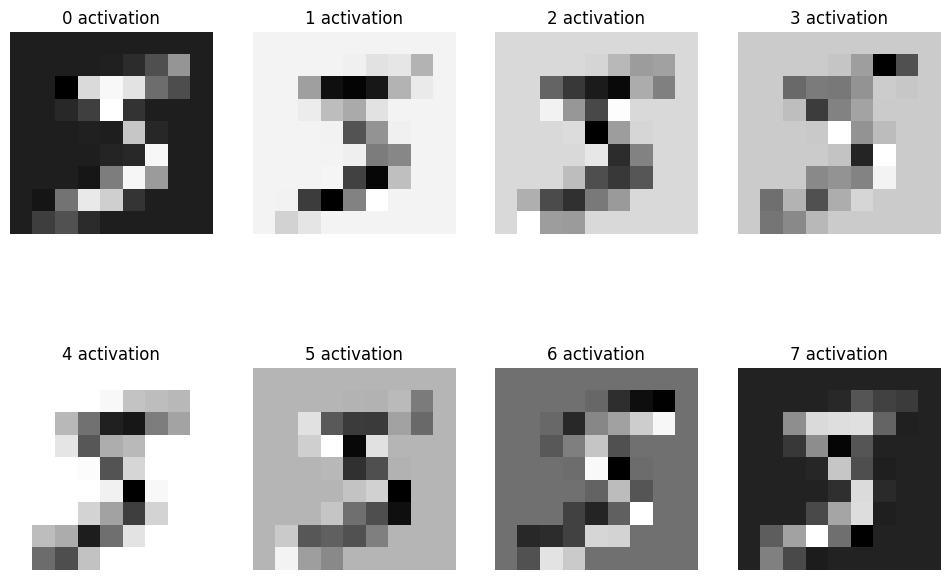

In [873]:
utils.visualize_activations(conv1_activations[0], 2, 4)

# Multiple convolutions

In [874]:
from typing import List

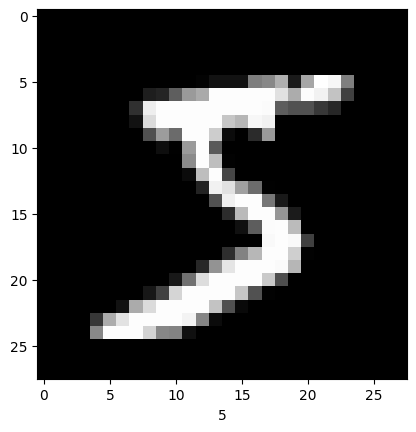

In [878]:
import matplotlib.pyplot as plt

img1 = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img1,cmap='gray')
plt.xlabel(y_train[0])
plt.show() # Show the image

In [879]:
img1 = np.expand_dims(img1, axis=0)
img1 = np.expand_dims(img1, axis=0)

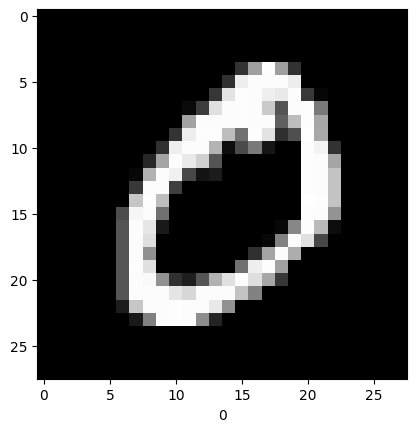

In [880]:
import matplotlib.pyplot as plt

img2 = x_train[1,:].reshape(28,28) # First image in the training set.
plt.imshow(img2,cmap='gray')
plt.xlabel(y_train[1])
plt.show() # Show the image

In [881]:
img2 = np.expand_dims(img2, axis=0)
img2 = np.expand_dims(img2, axis=0)

In [882]:
img1.shape

(1, 1, 28, 28)

In [883]:
img2.shape

(1, 1, 28, 28)

In [884]:
img_data = np.vstack((img1, img2))

print(img_data.shape)

(2, 1, 28, 28)


In [1288]:
conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 2)
relu_1 = ReluLayer("relu_1")
conv_2 = ConvLayer("conv_2", n_filters = 10, filter_size = 3, stride = 3)
relu_2 = ReluLayer("relu_2")

conv_block: List[Layer] = [conv_1, relu_1, conv_2, relu_2]

output_activations = img_data

for layer in conv_block:
    output_activations = layer.forward(output_activations)

n_samples=2, input_channels=1, input_width=28, input_height=28
height_idx=0, width_idx=0, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=2, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=4, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=6, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=8, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=10, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=12, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=14, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=16, filter_output.shape=(2, 13, 13), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, w

In [886]:
conv_1.conv_filter.shape

(8, 1, 3, 3)

In [887]:
conv_2.conv_filter.shape

(10, 8, 3, 3)

# Filter visualization

In [888]:
print(f"{conv_1.conv_filter.shape=}, {conv_2.conv_filter.shape=}")

conv_1.conv_filter.shape=(8, 1, 3, 3), conv_2.conv_filter.shape=(10, 8, 3, 3)


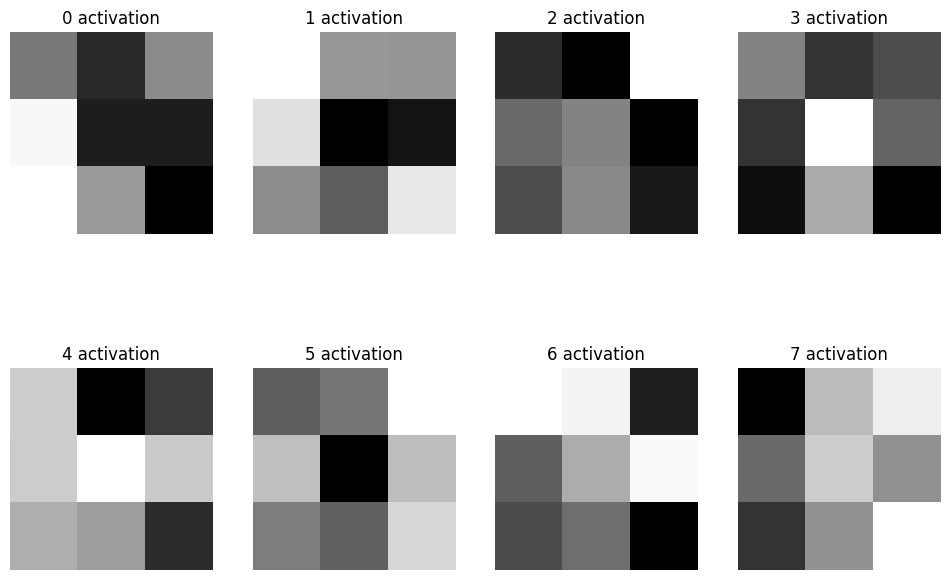

In [889]:
utils.visualize_filters(conv_1.conv_filter, 2, 4)

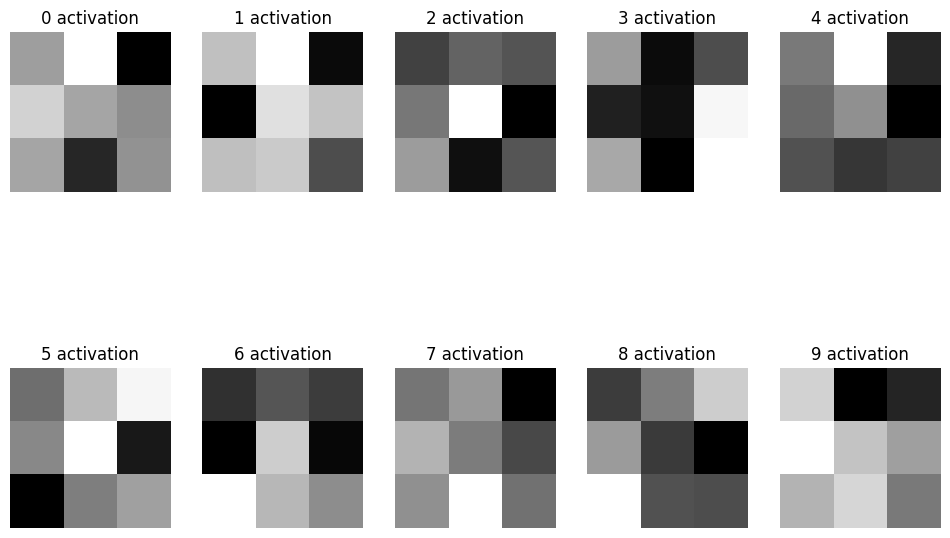

In [890]:
utils.visualize_filters(conv_2.conv_filter, 2, 5)

In [757]:
# def visualize_activations(images, rows, cols):
#     fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
#     for i, ax in enumerate(axes.flat):
#         img = images[i]
#         ax.imshow(img, cmap="gray")
#         ax.set_title(f"{i} activation")
#         ax.axis("off")
#     plt.show()


# Activation visualization

In [891]:
print(f"{conv_1.cached_output_activations.shape=}, {conv_2.cached_output_activations.shape=}")

conv_1.cached_output_activations.shape=(2, 8, 13, 13), conv_2.cached_output_activations.shape=(2, 10, 4, 4)


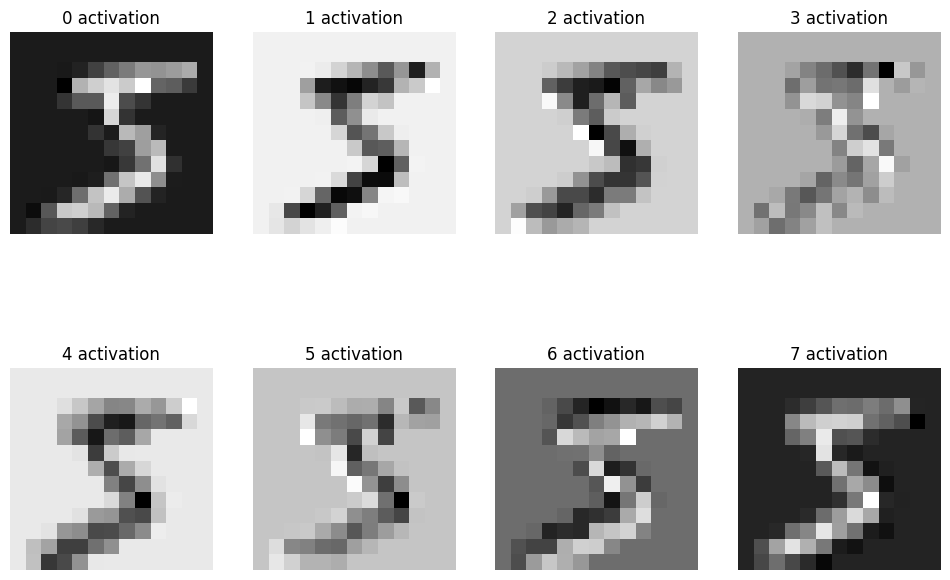

In [892]:
utils.visualize_activations(conv_1.cached_output_activations[0], 2, 4)

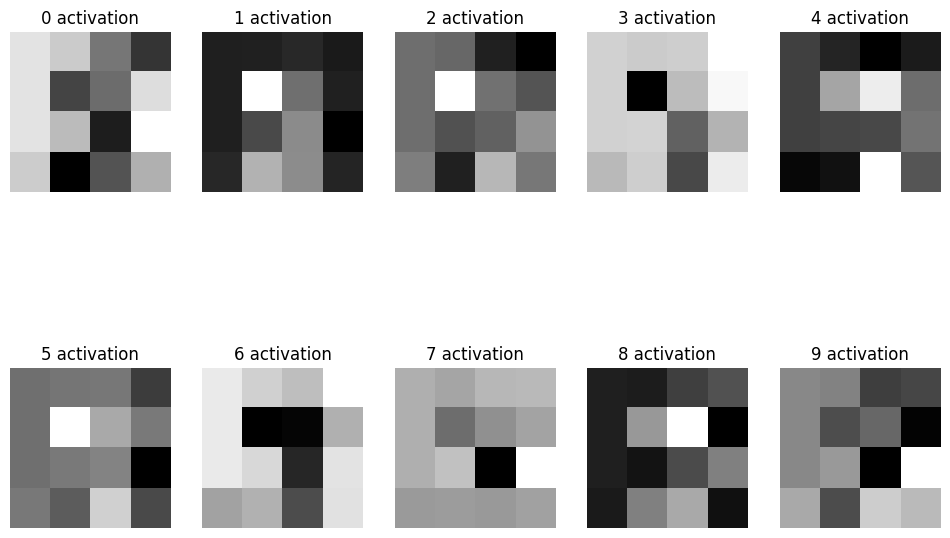

In [893]:
utils.visualize_activations(conv_2.cached_output_activations[0], 2, 5)

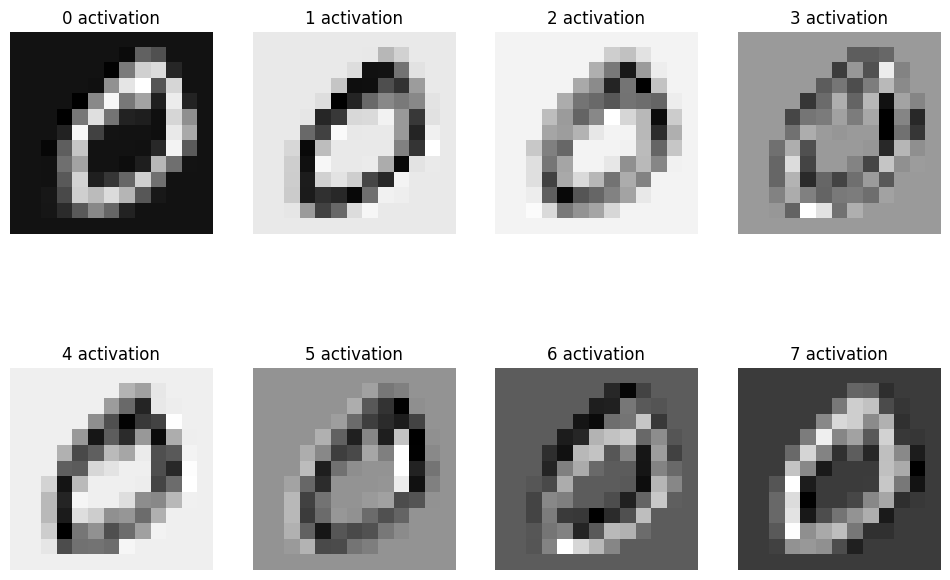

In [894]:
utils.visualize_activations(conv_1.cached_output_activations[1], 2, 4)

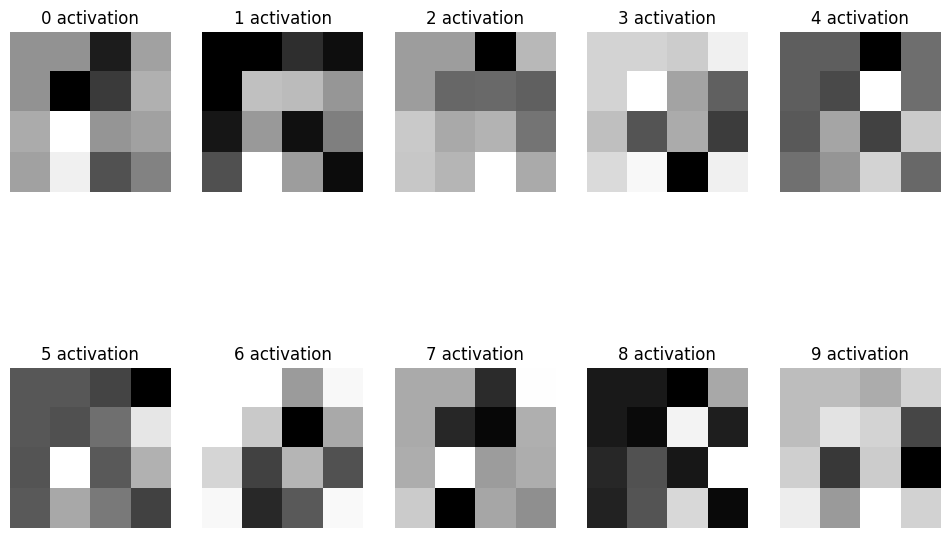

In [895]:
utils.visualize_activations(conv_2.cached_output_activations[1], 2, 5)

In [7]:
from layer import Layer 

class Flatten(Layer):
    def __init__(self, layer_name):
        super().__init__(layer_name)
        self.input_shape = None

    def forward(self, input_activations):
        self.input_shape = input_activations.shape
        return input_activations.ravel().reshape(self.input_shape[0], -1)
    
    def backward(self, global_gradients, learning_rate):
        return global_gradients.reshape(self.input_shape)

# Convolution back prop

In [8]:
class ConvLayer(Layer):
    def __init__(self, layer_name, n_filters = 8, filter_size = 3, stride = 1, debug = True):
        super().__init__(layer_name)
        np.random.seed(42)    
        self.filter_size = filter_size
        self.stride = stride
        self.n_filters = n_filters
        self.debug = debug
        self.cached_input_activations = None

    def get_patch(self, image, width_idx, height_idx, filter_size):
        return image[:, :, height_idx:height_idx+filter_size, width_idx: width_idx+filter_size]

    def forward(self, input_activations):
        '''
        @param input_activations - output of previous layer, will be of shape
        N x C x H x W 
        Conv forward

        1. Get the patch of the size similar to conv filter
        2. Perform convolution on that patch and store in an numpy array
        3. Do the above for all the filters
        4. Append all the filters output and return it for next layer

        '''
        self.cached_input_activations = input_activations
        first_activation = True
        n_samples, input_channels, input_width, input_height = input_activations.shape

        if self.debug:
            print(f"{n_samples=}, {input_channels=}, {input_width=}, {input_height=}")
            
        
        variance = 2/(input_channels + self.n_filters)
        self.conv_filter = np.random.normal(0.0, np.sqrt(variance),size=(self.n_filters, input_channels, self.filter_size, self.filter_size))

        output_shape = (int((input_width - self.filter_size) / self.stride)) + 1 
        output_activations = np.zeros([])

        for conv_filter in self.conv_filter:
            filter_output = np.zeros((n_samples, output_shape, output_shape))
            height_idx = 0
            filter_y = 0
            
            while (height_idx + self.filter_size) <= input_height:
                width_idx = 0
                filter_x = 0
                while (width_idx + self.filter_size) <= input_width:
                    patch = self.get_patch(input_activations, width_idx, height_idx, self.filter_size)
                                    
                    conv = np.sum(conv_filter * patch, axis=(1,2,3))
                    if self.debug:
                        print(f"{height_idx=}, {width_idx=}, {filter_output.shape=}, {patch.shape=}, {conv.shape=}")

                    
                    filter_output[:, filter_y, filter_x] = conv                    
                    width_idx += self.stride
                    filter_x += 1
                    
                height_idx += self.stride
                filter_y += 1
                # filter_output = filter_output.reshape(output_shape, output_shape)
            
            if first_activation:
                output_activations = filter_output
                output_activations = np.expand_dims(output_activations, axis=1)
                first_activation = False

            else:
                filter_output = np.expand_dims(filter_output, axis=1)
                if self.debug:
                    print(f"{output_activations.shape=}, {filter_output.shape=}")
                output_activations = np.append(output_activations, filter_output, axis=1)

            if self.debug:
                print(f"{output_activations.shape=}, {filter_output.shape=}")

        self.cached_output_activations = output_activations
        return output_activations

    def backward(self, global_gradients, learning_rate):
        '''
        Backward propagation for the convolutional filters

        https://deeplearning.cs.cmu.edu/F21/document/recitation/Recitation5/CNN_Backprop_Recitation_5_F21.pdf

        dL_input = global_gradients * filter
        dL_filter = global_gradients * local_gradients

        '''
        n_samples, input_channels, input_width, input_height = self.cached_input_activations.shape
        first_activation = True
        output_gradients = np.zeros_like(self.cached_input_activations, dtype=np.float64)
        local_gradients = np.zeros_like(self.conv_filter)

        for c_id, conv_filter in enumerate(self.conv_filter):
            # print(f"entering loop {c_id}")
            height_idx = 0
            filter_y = 0
            # filter_grad = np.zeros(shape=(self.n_filters, self.filter_size, self.filter_size))

            while height_idx + self.filter_size <= input_height:
                width_idx  = 0
                filter_x = 0

                while width_idx + self.filter_size <= input_width:
                    patch = self.get_patch(self.cached_input_activations, width_idx, height_idx, self.filter_size)
                    global_patch = global_gradients[:, c_id, filter_y, filter_x][:, np.newaxis, np.newaxis, np.newaxis]
                    prod_sum = np.sum((global_patch *  patch), axis=0)
                    local_gradients[np.newaxis, c_id] += prod_sum
                    temp = (global_patch) * conv_filter
                    output_gradients[:, :,  height_idx : height_idx + self.filter_size, width_idx : width_idx + self.filter_size] += temp
                
                    width_idx += self.stride
                    filter_x += 1

                height_idx += self.stride
                filter_y += 1


            # print(f"{local_gradients.shape=}, {filter_grad.shape=}")
            
            # local_gradients[c_id] = filter_grad[c_id]


        if self.debug:
            print(f"{local_gradients.shape=}")
        self.conv_filter -= learning_rate * (local_gradients / n_samples)

        return output_gradients
                           
        
        

In [9]:
a = np.zeros((8, 1, 3,3)) 
b = np.ones((1,3,3))

a[0] = b

In [1931]:
conv_1 = ConvLayer(layer_name="conv_1", n_filters=8, filter_size=3, stride=1, debug=False)
output_act = conv_1.forward(img_data)

# conv_1 = ConvLayer(layer_name="conv_1", n_filters=8, filter_size=3, stride=1, debug=False)
# output_act = conv_1.forward(img_data)
print(output_act.shape)


(2, 8, 26, 26)


In [1932]:
global_grad = np.random.randn(2, 8, 26, 26)

conv1_gradients = conv_1.backward(global_grad, 1e-2)

In [1933]:
conv_1.conv_filter.shape

(8, 1, 3, 3)

In [1934]:
conv_2.conv_filter.shape

(10, 8, 3, 3)

In [1935]:
conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 1)
relu_1 = ReluLayer("relu_1")
conv_2 = ConvLayer("conv_2", n_filters = 10, filter_size = 3, stride = 2)
relu_2 = ReluLayer("relu_2")

conv_block: List[Layer] = [conv_1, relu_1, conv_2, relu_2]

output_activations = img_data

for layer in conv_block:
    output_activations = layer.forward(output_activations)


print(output_activations.shape)

n_samples=2, input_channels=1, input_width=28, input_height=28
height_idx=0, width_idx=0, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=1, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=2, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=3, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=4, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=5, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=6, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=7, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width_idx=8, filter_output.shape=(2, 26, 26), patch.shape=(2, 1, 3, 3), conv.shape=(2,)
height_idx=0, width

In [1936]:
conv_1.conv_filter.shape

(8, 1, 3, 3)

In [1937]:
conv_2.conv_filter.shape

(10, 8, 3, 3)

In [1938]:
global_grad = output_activations

for layer in reversed(conv_block):
    global_grad = layer.backward(global_grad, 1e-06)
    # if layer.layer_name not in ["conv_1", "relu_1"]:
    #     global_grad = layer.backward(global_grad, 1e-06)


local_gradients.shape=(10, 8, 3, 3)
local_gradients.shape=(8, 1, 3, 3)


# Maxpool layer

In [10]:
class MaxPool(Layer):  # max pooling layer using pool size equal to 2
    def __init__(self, layer_name, stride=2, pool_size=2):
        super().__init__(layer_name)
        self.cached_input = None
        self.pool_stride = stride
        self.pool_size = pool_size
        self.mask_caches = {}

    def forward(self, activation):
        self.cached_input = activation

        n_samples, n_channels, h_prev, w_prev = activation.shape
        downsampled_h = ((h_prev - self.pool_size) // self.pool_stride) + 1  # compute output dimensions after the max pooling
        downsampled_w = ((w_prev - self.pool_size) // self.pool_stride) + 1

        downsampled = np.zeros((n_samples, n_channels, downsampled_h, downsampled_w))

        for channel_i in range(n_channels):
            height_idx = d_y = 0
            while (height_idx + self.pool_size <= h_prev):  
                width_idx = d_x = 0
                while (width_idx + self.pool_size <= w_prev): 
                    patch = activation[:, channel_i, height_idx : height_idx + self.pool_size, width_idx : width_idx + self.pool_size]
                    downsampled[:, channel_i, d_y, d_x] = np.max(patch, axis=(1,2))
                    width_idx += self.pool_stride  
                    d_x += 1

                height_idx += self.pool_stride
                d_y += 1

        return downsampled

    def backward(self, global_gradients, learning_rate):
        n_samples, n_channels, h_prev, w_prev = self.cached_input.shape
        
        output_gradient = np.zeros_like(self.cached_input)  # initialize derivative

        for c in range(n_channels):
            height_idx = out_y = 0
            while height_idx + self.pool_size <= h_prev:
                width_idx = out_x = 0
                while width_idx + self.pool_size <= w_prev:
                    patch = self.cached_input[:, c, height_idx : height_idx + self.pool_size, width_idx : width_idx + self.pool_size]  # obtain index of largest
                    (n, x, y) = np.unravel_index(np.nanargmax(patch), patch.shape)  # value in patch
                    output_gradient[:, c, height_idx + x, width_idx + y] += global_gradients[:, c, out_y, out_x]
                    width_idx += self.pool_stride
                    out_x += 1
                height_idx += self.pool_stride
                out_y += 1

        return output_gradient       

# Model end to end

In [190]:
from layer import Layer

In [11]:
class DenseLayer(Layer):
    def __init__(self, layer_name, input_nodes, output_nodes, debug = False):
        super().__init__(layer_name)
        self.debug = debug
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        '''
        Gloro/Xavier initialization for weights for faster convergence
        https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/
        '''
        limit = np.sqrt(2 / float(input_nodes + output_nodes))
        self.weights = np.random.normal(0.0, limit, size = (input_nodes, output_nodes))

        ''' 
        No initialization is required for bias,
        https://cs231n.github.io/neural-networks-2/#:~:text=Initializing%20the%20biases
        '''
        self.bias = np.zeros((1, output_nodes))

        #we need to cache the input and output from this layer for the purpose of backprop
        self.cached_input = None
        self.cached_output = None

    # overriden
    def forward(self, input_activations):
        '''

        @param input_activations - Output of previous layer
        @return softmax of logits

        Dense layer forward prop
        1. Flatten the input
        2. Dot product with weights and add the bias
        3. Cache the input and logits for backpop
        4. Apply softmax on logits and return it
        '''

        shape = input_activations.shape
        layer_input = input_activations
        layer_logits = np.dot(layer_input, self.weights) + self.bias

        self.cached_input = layer_input
        self.cached_output = layer_logits
        if self.debug:
            print(f"Cached output {self.cached_output}, ip shape {layer_input.shape}, op shape {layer_logits.shape}")
        return self.cached_output


    #overriden
    def backward(self, global_gradient, current_lr):
        '''
        @param global_gradient, gradients from the previous layer
        @param current_lr 


        @returns The gradient of Loss w.r.t to the input to this layer
        i.e the input_activations recieved during forward pass.

        Dense layer backward prop
        1. Calculate the gradients w.r.t to the weights
        2. Calculate the gradients w.r.t to the received activations
        and return it for usage in other previous layers.

        '''
        output_grad  = global_gradient
        samples = global_gradient.shape[0]

        assert output_grad.shape[1] == self.weights.T.shape[0]
        assert self.cached_input.T.shape[1] == output_grad.shape[0]

        input_grad = np.dot(output_grad, self.weights.T) / samples
        weight_grad = np.dot(self.cached_input.T, output_grad) / samples
        
        if self.debug:
            print(f"weights shape {self.weights.shape}, weight grad shape {weight_grad.shape}, input_shape {self.cached_input.shape}, input_grad shape {input_grad.shape}, ")

        self.weights -= current_lr * weight_grad
        self.bias -= current_lr * np.sum(output_grad, axis=0, keepdims=True) 

        return input_grad

In [176]:
from model import Sequential

In [1056]:

np.random.seed(42)


conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 1, debug=False)
relu_1 = ReluLayer("relu_1")
max_1 = MaxPool("max_pool_1", 2, 2)
conv_2 = ConvLayer("conv_2", n_filters = 10, filter_size = 3, stride = 1, debug=False)
relu_2 = ReluLayer("relu_2")
max_2 = MaxPool("max_pool_2", 2, 2)
flatten_1 = Flatten("flatten_1")
dense_1 = DenseLayer("Dense_1", 5408, 14, debug=False)
relu_3 = ReluLayer("relu_3")
dense_2 = DenseLayer("Dense_2", 14, 10, debug=False)


layers = [conv_1, relu_1, flatten_1, dense_1, relu_2, dense_2]

sequential_model = Sequential(layers)


In [1057]:
# ??sequential_model.train

In [1058]:
import mnist

In [1059]:
x_train, y_train, x_test, y_test = mnist.load()

In [1060]:
x_train.shape

(60000, 784)

In [1061]:
x_test.shape

(10000, 784)

In [1062]:
train_samples = x_train.shape[0]
test_samples = x_test.shape[0]

In [1063]:
x_train, x_test = x_train.reshape(train_samples, 1, 28, 28), x_test.reshape(test_samples, 1, 28, 28)

In [1064]:
import utils

In [1065]:
x_preprocessed = x_train[:10000]
y_preprocessed = y_train[:10000]

x_preprocessed = utils.minmax_normalize(x_preprocessed)

x_val_preprocessed = x_train[10000: 20000]
y_val_preprocessed = y_train[10000: 20000]

x_val_preprocessed = utils.minmax_normalize(x_val_preprocessed)

x_test_preprocessed = x_test
y_test_preprocessed = y_test

x_test_preprocessed = utils.minmax_normalize(x_test_preprocessed)


In [1066]:
x_preprocessed.shape, y_preprocessed.shape

((10000, 1, 28, 28), (10000,))

In [1067]:
sequential_model._validate([x_val_preprocessed, y_val_preprocessed])

(7.6, 2.4634465804786)

In [1068]:
sequential_model.train([x_preprocessed, y_preprocessed], [x_val_preprocessed, y_val_preprocessed], 20, 16, True, 1e-01)

----------
Epoch 1
Epoch Progress 99.84 %, batch 624, batch loss 1.2310691002513838, batch accuracy 62.555
Time 73.92006659507751 seconds
Train Accuracy 56.769999999999996, Validation accuracy 83.76
Train Loss 1.3323897160993623, Validation loss 0.5715589795417529
----------
----------
Epoch 2
Epoch Progress 8.80 %, batch 55, batch loss 0.548006293643307, batch accuracy 93.7555

KeyboardInterrupt: 

In [116]:
sequential_model.train([x_preprocessed, y_preprocessed], [x_val_preprocessed, y_val_preprocessed], 20, 16, True, 1e-01)

----------
Epoch 1
 Epoch Progress 99.84 %
Time 250.8758955001831 seconds
Train Accuracy 62.41, Validation accuracy 33.78
Train Loss 0.3453661181639033, Validation loss 5.164018001188026
----------
----------
Epoch 2
 Epoch Progress 99.84 %
Time 248.5676941871643 seconds
Train Accuracy 73.81, Validation accuracy 85.13
Train Loss 0.1936379716364748, Validation loss 1.642168520811222
----------
----------
Epoch 3
 Epoch Progress 3.36 %

KeyboardInterrupt: 

In [1958]:
sequential_model.train([x_preprocessed, y_preprocessed], [x_val_preprocessed, y_val_preprocessed], 20, 16, True, 1e-01)

----------
Epoch 1
 Epoch Progress 99.84 %
Time 254.60969972610474 seconds
Train Accuracy 62.41, Validation accuracy 33.78
Train Loss 0.3453661181639033, Validation loss 5.164018001188026
----------
----------
Epoch 2
 Epoch Progress 99.84 %
Time 244.67271161079407 seconds
Train Accuracy 73.81, Validation accuracy 85.13
Train Loss 0.1936379716364748, Validation loss 1.642168520811222
----------
----------
Epoch 3
 Epoch Progress 99.84 %
Time 255.46696066856384 seconds
Train Accuracy 75.01, Validation accuracy 78.14999999999999
Train Loss 0.18329618247777044, Validation loss 4.720152975675934
----------
----------
Epoch 4
 Epoch Progress 4.48 %

KeyboardInterrupt: 

In [1888]:
sequential_model.test([x_test, y_test])

(72.34, 46.047096689694925)

# New data

- preprocess the new data
- train it on just DNN
- then on CNN
- setup tensorboard for experiment tracking

# Preprocessing

In [502]:
import sklearn
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [503]:
data = {}
for folder in glob.glob("../data/*"):
    f_name = folder.split("\\")[1]
    if f_name not in data:
        n_files = glob.glob(f"{folder}\*.jpg")
        data[f_name] = len(n_files)
        print(f_name, len(n_files))


+ 25112
- 33997
= 13104
div 868
times 3251
u 1269
v 1558
w 556
y 9340
z 5870


In [504]:
sorted(data.items(), key = lambda x:x[1], reverse=True)

[('-', 33997),
 ('+', 25112),
 ('=', 13104),
 ('y', 9340),
 ('z', 5870),
 ('times', 3251),
 ('v', 1558),
 ('u', 1269),
 ('div', 868),
 ('w', 556)]

In [505]:
df = pd.DataFrame()
df["Distribution"] = list(data.values())
df["Classes"] = list(data.keys())

In [506]:
df.head()

,Distribution,Classes
0,25112,+
1,33997,-
2,13104,=
3,868,div
4,3251,times


In [507]:
df = df.sort_values("Distribution", ascending=False)

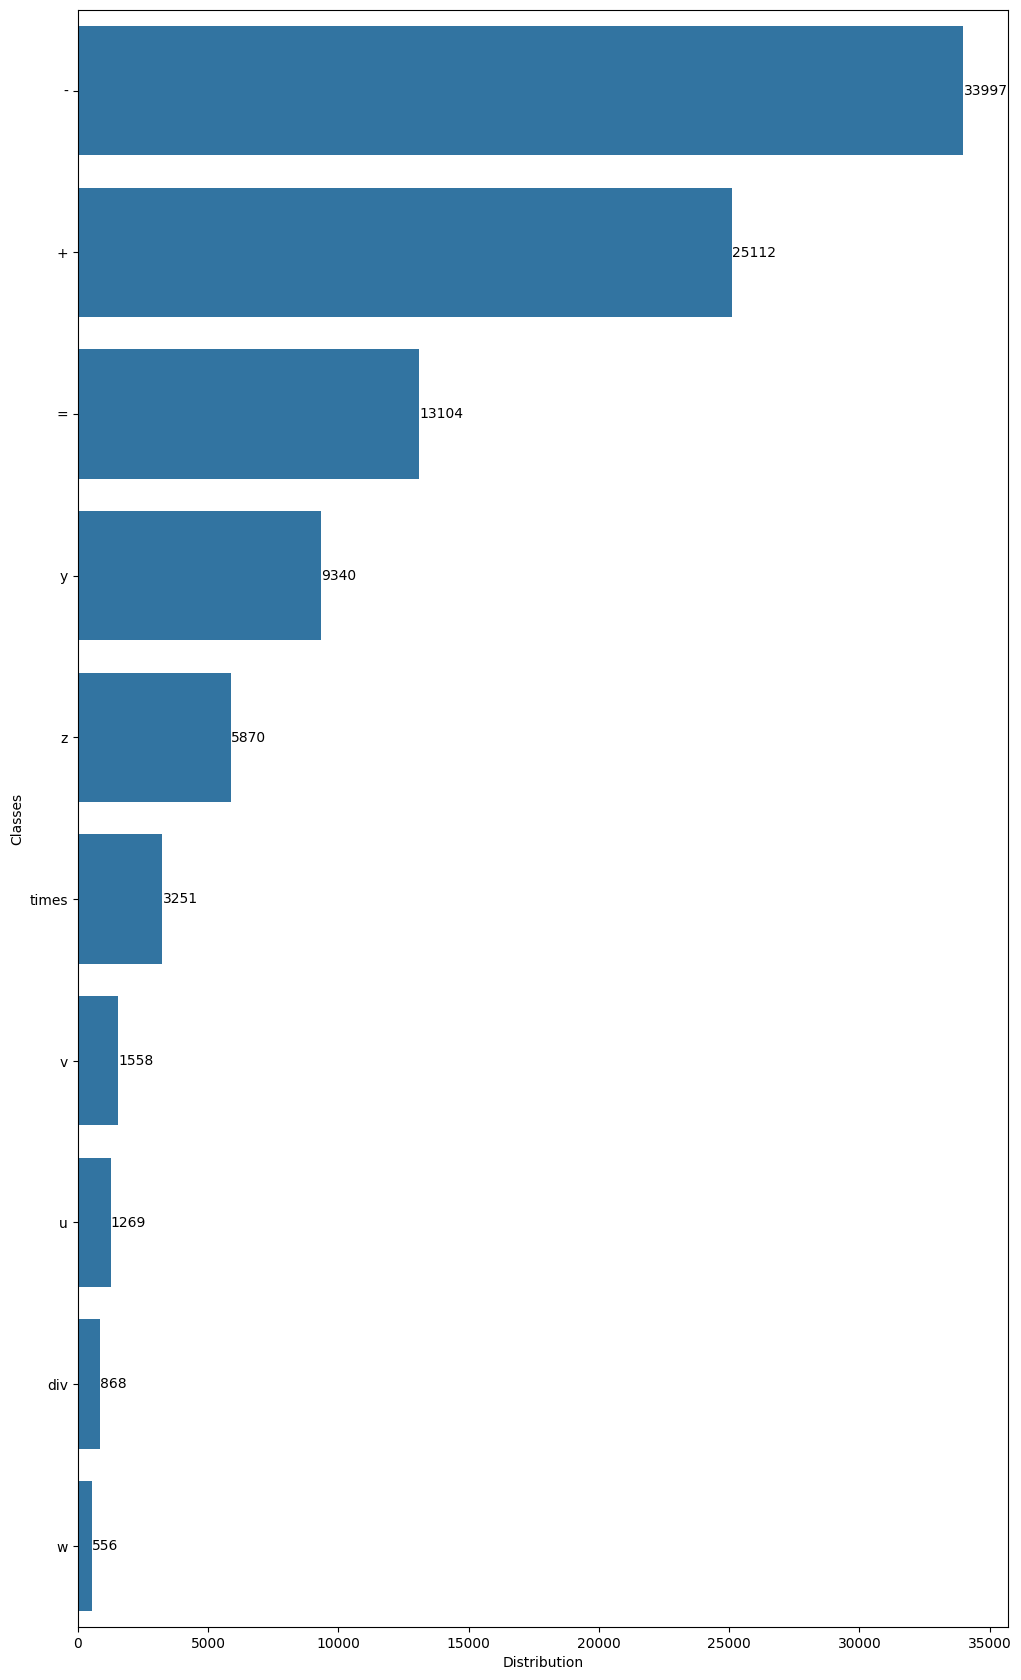

In [508]:
plt.figure(figsize=(12,21))
ax = sns.barplot(y="Classes", x="Distribution", data=df)
ax.bar_label(ax.containers[0])
plt.show()

In [509]:
labels = sorted(list(df["Classes"]))
labels_map = {label:10+index for index, label in enumerate(labels)}

In [510]:
labels_map

{'+': 10,
 '-': 11,
 '=': 12,
 'div': 13,
 'times': 14,
 'u': 15,
 'v': 16,
 'w': 17,
 'y': 18,
 'z': 19}

In [746]:
x_mnist_test.shape

(10000, 784)

In [ ]:
import cv2

In [747]:
x_mnist_train, y_mnist_train, x_mnist_test, y_mnist_test = mnist.load()

x_mnist_train, x_mnist_test = x_mnist_train.reshape((x_mnist_train.shape[0],28, 28)), x_mnist_test.reshape((x_mnist_test.shape[0], 28, 28))

In [748]:

kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]])
reshaped_x_train_mnist, reshaped_x_test_mnist = [], []


for img in x_mnist_train:
    img = cv2.resize(img, (55,55), cv2.INTER_CUBIC, fx=0.1, fy=0.1)
    img = cv2.filter2D(img, -1, kernel)
    reshaped_x_train_mnist.append(img)

for img in x_mnist_test:
    img = cv2.resize(img, (55,55), cv2.INTER_CUBIC, fx=0.1, fy=0.1)
    img = cv2.filter2D(img, -1, kernel)
    reshaped_x_test_mnist.append(img)

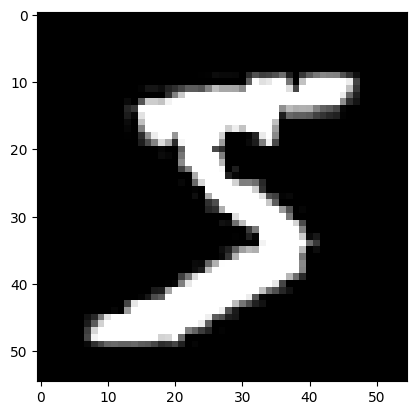

In [751]:
plt.imshow(reshaped_x_train_mnist[0], cmap="gray")

In [512]:
list(df["Classes"])

['-', '+', '=', 'y', 'z', 'times', 'v', 'u', 'div', 'w']

In [918]:
import glob

import os
#import cv2
import numpy as np
from pathlib import Path
import glob
from PIL import Image
from numpy import asarray
from sklearn.model_selection import train_test_split
import cv2
# Specify the path to your dataset
images = []
labels = []
goodlabels = ["+","-","=","div","times","u","v","z","w","y"]
path = '../data/'

for label in os.listdir(path):
    if(label in goodlabels): 
        label_path = os.path.join(path,label)
        print(label_path)
        counter = 0
        for filename in os.listdir(label_path):
            if(counter > 7000):
                break
            counter = counter + 1
            img_path = os.path.join(label_path,filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.GaussianBlur(img, (5,5), 0)
            img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)
            img = cv2.dilate(img, np.ones((2,2), np.uint8), iterations=1)
            images.append(img)
            labels.append(labels_map[label])
# print(finalLabel)
# print(finalImage[0])


../data/+
../data/-
../data/=
../data/div
../data/times
../data/u
../data/v
../data/w
../data/y
../data/z


In [919]:
images = np.asarray(images)
labels = np.asarray(labels)

In [920]:
np.unique(labels, return_counts=True)

(array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([7001, 7001, 7001,  868, 3251, 1269, 1558,  556, 7001, 5870],
       dtype=int64))

In [921]:
src = "../data/+/+_20.jpg"

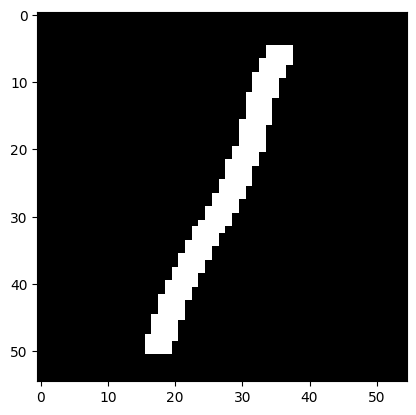

In [922]:
# img = cv2.imread(src)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.GaussianBlur(img, (5,5), 0)
# img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# img = cv2.dilate(img, np.ones((2,2), np.uint8), iterations=1)
# img = cv2.resize(img, (45, 45))
# cv2.
# img = cv2.dilate(img, )
plt.imshow(images[21260], cmap="gray")


In [923]:
images = np.append(reshaped_x_train_mnist, images, axis=0)
images = np.append(images, reshaped_x_test_mnist, axis=0)

In [1080]:
y_train[40484]

10

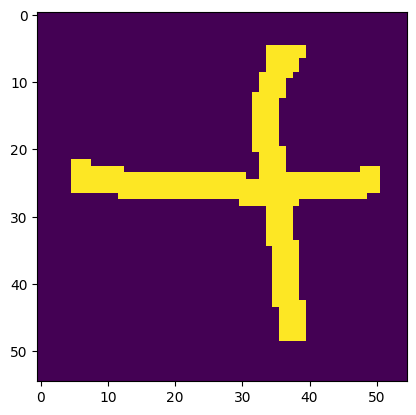

In [1079]:
plt.imshow(X_train[40484])

In [924]:
np.unique(labels, return_counts=True)

(array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([7001, 7001, 7001,  868, 3251, 1269, 1558,  556, 7001, 5870],
       dtype=int64))

In [925]:
labels = np.append(y_mnist_train, labels, axis=0)
labels = np.append(labels, y_mnist_test, axis=0)

In [926]:
numbers_map = {label:idx for idx, label in enumerate(list("0123456789"))}
numbers_map.update(labels_map)

In [927]:
numbers_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 '=': 12,
 'div': 13,
 'times': 14,
 'u': 15,
 'v': 16,
 'w': 17,
 'y': 18,
 'z': 19}

Text(0.5, 0, '2')

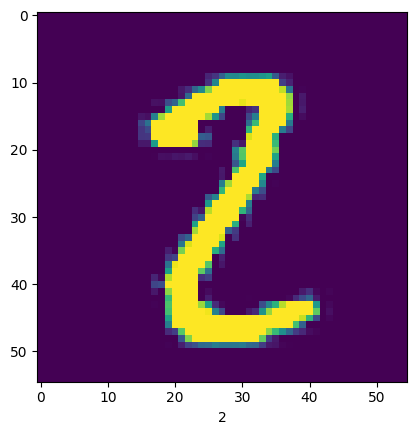

In [983]:
r = np.random.randint(labels.shape[0])
plt.imshow(images[r])
plt.xlabel(labels[r])

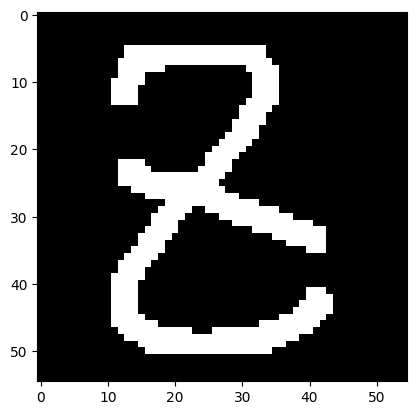

In [984]:
r = np.random.randint(len(images))
plt.imshow(images[r].reshape(55,55), cmap="gray")

In [985]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958, 7001,
        7001, 7001,  868, 3251, 1269, 1558,  556, 7001, 5870], dtype=int64))

In [1078]:
# Now here we will split the data into train test and validate
# basically we allocate 30% of data to test and validate
# now we will allocate 15% of total data to test and 15% of total data to validate
temp_X, X_test, temp_Y, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(temp_X, temp_Y, test_size=0.1, random_state=42)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
X_val, y_val = np.array(X_val), np.array(y_val)

# Now preprocessed_data contains your preprocessed images as NumPy arrays, and labels contain corresponding class labels
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(80190, 55, 55)
(22276, 55, 55)
(8910, 55, 55)


In [1081]:
labels_map = numbers_map
print(labels_map)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '-': 11, '=': 12, 'div': 13, 'times': 14, 'u': 15, 'v': 16, 'w': 17, 'y': 18, 'z': 19}


In [1082]:
np.unique(y_train, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([4957, 5552, 5034, 5180, 4859, 4533, 4934, 5246, 5004, 5020, 5002,
        5096, 5059,  627, 2365,  929, 1121,  393, 5095, 4184], dtype=int64))

In [1083]:
np.unique(y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([1402, 1630, 1446, 1376, 1390, 1274, 1416, 1466, 1289, 1397, 1439,
        1367, 1361,  173,  649,  246,  312,  109, 1344, 1190], dtype=int64))

In [1084]:
np.unique(y_val, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([544, 695, 510, 585, 575, 506, 526, 581, 532, 541, 560, 538, 581,
         68, 237,  94, 125,  54, 562, 496], dtype=int64))

In [1085]:
def idtolabel(labels_map, y):
    for key, value in labels_map.items():
        if y == value:
            return key
        
    return -1


In [1086]:
idtolabel(labels_map, y_train[0])

'7'

In [1087]:
labels_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 '=': 12,
 'div': 13,
 'times': 14,
 'u': 15,
 'v': 16,
 'w': 17,
 'y': 18,
 'z': 19}

18


Text(0.5, 0, 'y')

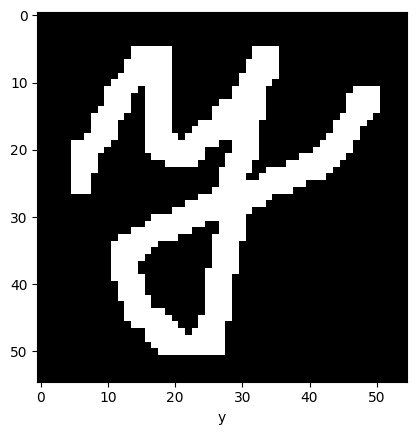

In [1126]:
x_data, y_data = X_train, y_train
r = np.random.randint(0,len(x_data))
plt.imshow(x_data[r], cmap="gray")
print(y_data[r])
plt.xlabel(idtolabel(labels_map, y_data[r]))

# Model

In [829]:
import utils

In [1191]:
X_train_preprocessed = X_train
y_train_preprocessed = y_train
X_train_preprocessed = np.expand_dims(X_train_preprocessed, axis=1)
X_train_preprocessed = utils.minmax_normalize(X_train_preprocessed)

X_val_preprocessed = X_val
y_val_preprocessed = y_val
X_val_preprocessed = np.expand_dims(X_val_preprocessed, axis=1)
X_val_preprocessed = utils.minmax_normalize(X_val_preprocessed)

X_test_preprocessed = X_test
y_test_preprocessed = y_test
X_test_preprocessed = np.expand_dims(X_test_preprocessed, axis=1)
X_test_preprocessed = utils.minmax_normalize(X_test_preprocessed)

In [1211]:
x_mnist_train_c[100]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

(1, 55, 55)


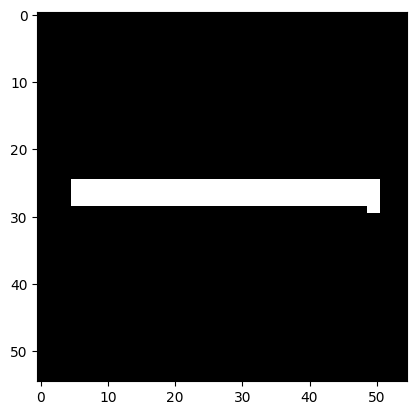

In [1214]:
print(X_train_preprocessed[100].shape)

plt.imshow(X_train_preprocessed[100][0], cmap="gray")

In [1129]:
X_train_preprocessed.shape

(80190, 1, 55, 55)

In [1130]:
x_data.shape

(80190, 55, 55)

Text(0.5, 0, '5')

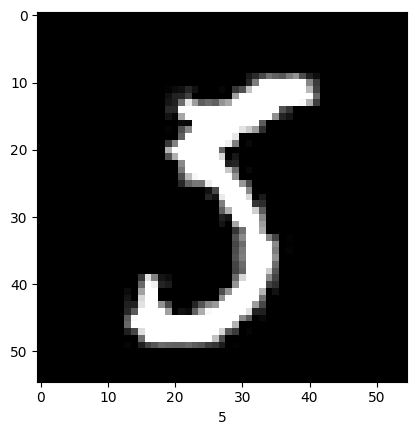

In [1162]:
x_data, y_data = X_train_preprocessed, y_train_preprocessed
r = np.random.randint(0,len(x_data))
plt.imshow(x_data[r][0], cmap="gray")
plt.xlabel(idtolabel(labels_map, y_data[r]))

In [246]:
# from model import Sequential
# np.random.seed(42)


# conv_1 = ConvLayer("conv_1", n_filters = 10, filter_size = 3, stride = 1, debug=False)
# relu_1 = ReluLayer("relu_1")
# conv_2 = ConvLayer("conv_2", n_filters = 10, filter_size = 3, stride = 2, debug=False)
# relu_2 = ReluLayer("relu_2")
# flatten_1 = Flatten("flatten_1")
# dense_1 = DenseLayer("Dense_1", 4410, 84, debug=False)
# relu_3 = ReluLayer("relu_3")
# dense_2 = DenseLayer("Dense_2", 84, len(labels_map), debug=False)


# layers =  [conv_1, relu_1, conv_2, relu_2, flatten_1, dense_1, relu_3, dense_2]

# sequential_model = Sequential(layers)

In [875]:
# model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(45, 45, 1)))
# model.add(tf.keras.layers.MaxPool2D(strides=2))

# # Second Convolutional Block
# model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(tf.keras.layers.MaxPool2D(strides=2))

# # Classifier Head
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dense(84, activation='relu'))
# model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [1219]:
from model import Sequential

np.random.seed(42)


conv_1 = ConvLayer("conv_1", n_filters = 8, filter_size = 3, stride = 1, debug=False)
relu_1 = ReluLayer("relu_1")
max_1 = MaxPool("max_pool_1", 2, 2)

# conv_2 = ConvLayer("conv_2", n_filters = 12, filter_size = 5, stride = 1, debug=False)
# relu_2 = ReluLayer("relu_2")
# max_2 = MaxPool("max_pool_2", 2, 2)

flatten_1 = Flatten("flatten_1")

dense_1 = DenseLayer("Dense_1", 22472, 256, debug=False)
relu_3 = ReluLayer("relu_3")

dense_2 = DenseLayer("Dense_2", 256, len(labels_map), debug=False)
# relu_4 = ReluLayer("relu_4")

# dense_3 = DenseLayer("Dense_3", 42, len(labels_map), debug=False)

layers = [conv_1, relu_1, flatten_1, dense_1, relu_2, dense_2]

sequential_model = Sequential(layers)


In [1220]:
labels_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 '=': 12,
 'div': 13,
 'times': 14,
 'u': 15,
 'v': 16,
 'w': 17,
 'y': 18,
 'z': 19}

In [1135]:
# sequential_model.train??

In [1136]:
X_train.shape, X_val.shape

((80190, 55, 55), (8910, 55, 55))

In [1137]:
X_val_preprocessed.shape

(8910, 1, 55, 55)

In [1138]:
np.unique(y_train_preprocessed, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([4957, 5552, 5034, 5180, 4859, 4533, 4934, 5246, 5004, 5020, 5002,
        5096, 5059,  627, 2365,  929, 1121,  393, 5095, 4184], dtype=int64))

In [1139]:
y_val_preprocessed.shape, X_val_preprocessed.shape

((8910,), (8910, 1, 55, 55))

In [1140]:
# # First Convolutional Block
# model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(45, 45, 1)))
# model.add(tf.keras.layers.MaxPool2D(strides=2))

# # Second Convolutional Block
# model.add(tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
# model.add(tf.keras.layers.MaxPool2D(strides=2))

# # Classifier Head
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dense(84, activation='relu'))
# model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [1164]:
x_mnist_train_c, x_mnist_test_c = np.expand_dims(x_mnist_train, axis=1), np.expand_dims(x_mnist_test, axis=1)

In [1179]:
x_mnist_train_c, x_mnist_test_c  = utils.minmax_normalize(x_mnist_train_c), utils.minmax_normalize(x_mnist_test_c)

In [1188]:
X_train_preprocessed[0].max()

255

In [1186]:
x_mnist_train_c[0]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

In [1165]:
x_mnist_train_c.shape

(60000, 1, 28, 28)

In [1166]:
y_mnist_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [1167]:
y_train

array([7, 2, 0, ..., 2, 7, 9])

In [1221]:
sequential_model._validate([X_val_preprocessed, y_val_preprocessed]) # without training

(6.11672278338945, 3.1512037721007933)

In [1222]:
sequential_model.train([X_train_preprocessed[:10000], y_train_preprocessed[:10000]], [X_val_preprocessed, y_val_preprocessed], 20, 16, True, 1e-01)

----------
Epoch 1
Epoch Progress 66.40 %, batch 415, batch loss 0.794558918179702, batch accuracy 75.0575

In [156]:
conv_1.cached_output_activations.shape

(16, 8, 43, 43)

In [ ]:
utils.plot_accuracy_curve(sequential_model.train_accuracy, sequential_model.validation_accuracy)

In [ ]:
utils.plot_loss_curve(sequential_model.train_loss, sequential_model.validation_loss)

In [ ]:
utils.plot_learning_curve(sequential_model.validation_loss)
